In [1]:
import gymnasium as gym
import ray
from ray import air, tune
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import get_trainable_cls

In [2]:
ray.__version__
# using nightly 3.0.0 build since gymnasium isn't supported in 2.3

'3.0.0.dev0'

In [3]:
ray.init(num_cpus=None, num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-01-07 19:53:32,504	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8266


In [4]:
import platoonenv
env_cls = platoonenv.InOutDangerEnv
env=env_cls()

In [5]:
ray.rllib.utils.check_env(env)

2023-01-07 19:53:53,233	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-01-07 19:53:53,234	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [6]:
# env_name = "CartPole-v1"
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig
train_class = "PPO"
param_space = (
    PPOConfig()
    .environment(env_cls)
    .framework("torch")
    .rollouts(num_rollout_workers=10)
    .resources(num_gpus=1)
    
)
# train_class="DQN"
# config = (
#     DQNConfig()
#     .environment(env_cls)
#     .framework("torch")
#     .rollouts(num_rollout_workers=10)
#     .resources(num_gpus=1)
# )

In [7]:
stop = {
    "training_iteration": 50,
    "timesteps_total": 100_000,
    "episode_reward_mean": env.metadata["reward_threshold"],
}
print(stop["episode_reward_mean"])

-48


In [8]:
run_config=air.RunConfig(
    stop=stop,
    verbose=2,
    checkpoint_config=air.CheckpointConfig(
        checkpoint_frequency=1, checkpoint_at_end=True
    ),
)

In [9]:
print(run_config)

RunConfig(stop={'training_iteration': 50, 'timesteps_total': 100000, 'episode_reward_mean': -48}, checkpoint_config=CheckpointConfig(checkpoint_frequency=1, checkpoint_at_end=True), verbose=2)


In [10]:
resume = False
resume_path = "C:/Users/TeamD/ray_results/PPO"
if resume:
    tuner = tune.Tuner.restore(resume_path)
else:
    tuner = tune.Tuner(
        train_class,
        param_space=param_space.to_dict(),
        run_config=run_config,
    )

In [11]:
results = tuner.fit()

(PPO pid=4524) 2023-01-07 19:54:13,401	WARNING algorithm_config.py:614 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(RolloutWorker pid=22036) 2023-01-07 19:54:29,989	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=22036) 2023-01-07 19:54:29,989	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=22036) 2023-01-07 19:54:30,043	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=22036) 2023-01-07 19:54:30,043	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=24644) 2023-01-07 19:54:30,189	INFO policy.py:1196 -- Policy (worker=6) running on CPU.
(RolloutWork

Trial name,agent_timesteps_total,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,timers
PPO_InOutDangerEnv_f252c_00000,100000,"{'num_env_steps_sampled': 100000, 'num_env_steps_trained': 100000, 'num_agent_steps_sampled': 100000, 'num_agent_steps_trained': 100000}",{},10,{},-51,-73.08,-174,400,"{'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'cur_kl_coeff': 0.3, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 9.17215512388496, 'policy_loss': -0.044242910889568186, 'vf_loss': 9.21086962915236, 'vf_explained_var': -4.8132352931525116e-08, 'kl': 0.018428052802423323, 'entropy': 1.9827778520122652, 'entropy_coeff': 0.0}, 'model': {}, 'num_grad_updates_lifetime': 22785.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 100000, 'num_env_steps_trained': 100000, 'num_agent_steps_sampled': 100000, 'num_agent_steps_trained': 100000}",100000,100000,100000,4000,100000,4000,0,10,0,0,4000,"{'cpu_util_percent': 29.915384615384614, 'ram_util_percent': 72.37692307692306, 'gpu_util_percent0': 0.3123076923076923, 'vram_util_percent0': 0.15997770345596432}",{},{},{},"{'mean_raw_obs_processing_ms': 0.8466101922865881, 'mean_inference_ms': 1.6149268676228383, 'mean_action_processing_ms': 0.1555506032343543, 'mean_env_wait_ms': 0.12382752727763723, 'mean_env_render_ms': 0.0}","{'training_iteration_time_ms': 11162.518, 'load_time_ms': 2.7, 'load_throughput': 1481641.203, 'learn_time_ms': 10001.82, 'learn_throughput': 399.927, 'synch_weights_time_ms': 13.402}"


2023-01-07 19:59:08,710	INFO tune.py:774 -- Total run time: 305.27 seconds (304.74 seconds for the tuning loop).


In [38]:
run_config

Setting,Value
Name,
Local results directory,
Verbosity,2
Log to file,False
Setting,Value
Max failures,0
Fail fast,False
Setting,Value
Upload directory,
Sync on checkpoint,True


In [23]:
tuner2 = tune.Tuner.restore(str(checkpoint))

RuntimeError: Could not find Tuner state in restore directory. Did you passthe correct path (including experiment directory?) Got: Checkpoint(local_path=C:\Users\TeamD\ray_results\PPO\PPO_InOutDangerLongEnv_1b8f1_00000_0_2023-01-04_00-53-26\checkpoint_000025)

In [12]:
checkpoint = results.get_best_result().checkpoint
# Checkpoint(local_path=C:\Users\TeamD\ray_results\PPO\PPO_PlatoonEnvV1_56ad8_00000_0_2022-12-31_15-04-31\checkpoint_000200)
# Checkpoint(local_path=C:\Users\TeamD\ray_results\PPO\PPO_PlatoonEnvV1_05ce9_00000_0_2023-01-02_23-56-45\checkpoint_000200)
assert checkpoint is not None, "checkpoint doesn't exist, training failed?"
print(checkpoint)
algo = Algorithm.from_checkpoint(checkpoint)

2023-01-07 19:59:31,562	WARNING algorithm_config.py:614 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.


Checkpoint(local_path=C:\Users\TeamD\ray_results\PPO\PPO_InOutDangerEnv_f252c_00000_0_2023-01-07_19-54-03\checkpoint_000025)


(RolloutWorker pid=1876) 2023-01-07 19:59:43,960	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=1876) 2023-01-07 19:59:43,960	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=20400) 2023-01-07 19:59:44,005	INFO policy.py:1196 -- Policy (worker=4) running on CPU.
(RolloutWorker pid=20400) 2023-01-07 19:59:44,005	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=29404) 2023-01-07 19:59:44,064	INFO policy.py:1196 -- Policy (worker=10) running on CPU.
(RolloutWorker pid=29404) 2023-01-07 19:59:44,065	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=16532) 2023-01-07 19:59:44,172	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=16532) 2023-01-07 19:59:44,172	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' a

In [26]:
import numpy as np
import pandas as pd
num_episodes = 0
episode_reward = 0.0
episode_steps = 0
truncated_already = False
actions = []
rewards = []
obs, info = env.reset()
data = []
while num_episodes < 10:
    # Compute an action (`a`).
    a = algo.compute_single_action(
        observation=obs,
        explore=False,
        policy_id="default_policy",  # <- default value
    )
    # Send the computed action `a` to the env.
    obs, reward, done, truncated, _ = env.step(a)
    data.append([obs, a, reward, done or truncated])
    episode_reward += reward
    episode_steps += 1

    if done or truncated:
        print(f"Episode done: Total reward = {episode_reward}, steps = {episode_steps}")
        obs, info = env.reset()
        actions = []
        rewards = []
        num_episodes += 1
        episode_steps = 0
        episode_reward = 0.0
        truncated_already = False

Episode done: Total reward = -77.0, steps = 10
Episode done: Total reward = -95.0, steps = 10
Episode done: Total reward = -85.0, steps = 10
Episode done: Total reward = -85.0, steps = 10
Episode done: Total reward = -95.0, steps = 10
Episode done: Total reward = -95.0, steps = 10
Episode done: Total reward = -95.0, steps = 10
Episode done: Total reward = -95.0, steps = 10
Episode done: Total reward = -77.0, steps = 10
Episode done: Total reward = -95.0, steps = 10


In [27]:
obs, info = env.reset()
from itertools import count
for i in count():
    a = algo.compute_single_action(
        observation=obs,
        explore=False,
        policy_id="default_policy",  # <- default value
    )
    # Send the computed action `a` to the env.
    obs, reward, done, truncated, _ = env.step(a)
    print(a, reward)
    if done or truncated:
        break

9 -9.0
10 -8.0
4 -7.0
10 -8.0
10 -7.0
10 -8.0
10 -7.0
10 -8.0
10 -7.0
10 -8.0


In [13]:
env.reset()

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., -10., -10.,   0.],
       dtype=float32),
 {})

In [14]:
env.step(0)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., -10., -10.,   0.],
       dtype=float32),
 -10.0,
 False,
 False,
 {})

(array([913., 914., 919., 892., 923., 911., 945., 877., 874., 887., 945.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

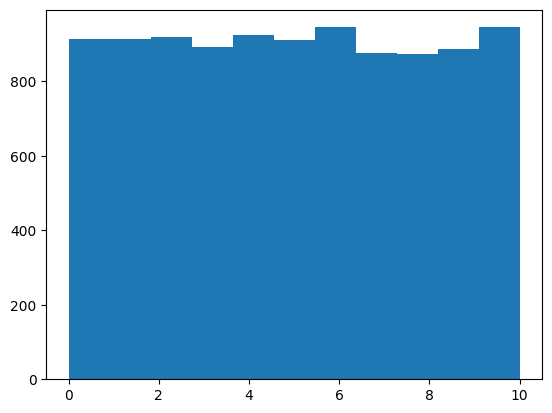

In [15]:
import matplotlib.pylab as plt
plt.hist([env.action_space.sample() for _ in range(10000)], bins=env.action_space.n)

In [16]:
# algo.stop()
# ray.shutdown()